# Running pySUMMA on PLUMBER sites

This notebook outlines the process for managing and analyzing a large number of SUMMA simulations.  We begin with some standard setup steps to import libraries and set constants that will be used throughout the rest of the analysis.

In [10]:
%pylab inline
import os
import time
import glob
import operator
import xarray as xr
import itertools
import summa_plot as sp
import pysumma.Simulation
import scipy.stats
import pandas as pd
import matplotlib as mpl
from pprint import pprint
from fastdtw import fastdtw
from functools import reduce
from scipy.special import psi, inv_boxcox
from jupyterthemes import jtplot
from sklearn.neighbors import NearestNeighbors

jtplot.style('grade3', fscale=1.3)
jtplot.figsize(x=18, y=10)
mpl.rcParams['figure.figsize'] = (18, 10)

MM_PER_M = 1000
SEC_PER_MIN = 60
MIN_PER_HOUR = 60
HOUR_PER_DAY = 24
DAY_PER_YEAR = 365
# Timestep is 1 hour in our case
SEC_PER_TIMESTEP = SEC_PER_MIN * MIN_PER_HOUR

user = os.environ['USER']
sites = ['Amplero', 'Blodgett', 'Bugac', 'ElSaler', 'ElSaler2', 'Espirra', 'FortPeck', 
         'Harvard', 'Hesse', 'Howard', 'Howlandm', 'Hyytiala', 'Kruger', 'Loobos', 'Merbleue',
         'Mopane', 'Palang', 'Sylvania', 'Tumba', 'UniMich']
fman_template = "/pool0/data/"+user+"/PLUMBER_data/sites/{}/settings/summa_zFileManager_{}.txt"
oc_template = "/pool0/data/"+user+"/PLUMBER_data/sites/{}/settings/meta/summa_zModelOutput.txt"
fman_dict = {s: fman_template.format(s, s) for s in sites}

Populating the interactive namespace from numpy and matplotlib


/pool0/data/andrbenn/.conda/all/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['bench']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Set up variables of interest

We will need to make sure that the variables contained in the `wb_vars` list are in the output.  This will be set automatically before running SUMMA by modifying the `OutputControl` object.  We will break the water balance into 5 components:

1. Precipitation (mm/timestep)
2. Evapotranspiration (mm/timestep)
3. Runoff (mm/timestep)
4. Soil moisture + canopy moisture (mm)
5. Snow water equivalent (mm)

By default precipitation and evapotranspiration components are in (mm/second) and the runoff component is in (m/sec) so they will have to be converted by multiplying by the correct factors defined above. Additionally, these quantities may have several components.  Each of the components is listed below as a list of it's subcomponents in the `wb_dict` variable.  The unit conversion constant is in `wb_multiplier`.  A function will be given in the next section to do all of the necessary post-processing.

In [2]:
wb_vars = ['pptrate', 'scalarGroundEvaporation', 'scalarCanopyEvaporation',
           'scalarSnowSublimation', 'scalarCanopySublimation', 'scalarTotalRunoff', 
           'scalarSWE', 'scalarTotalSoilLiq',  'scalarTotalSoilIce', 
           'scalarCanopyIce', 'scalarCanopyLiq', 'scalarCanopyTranspiration', 
           'scalarLatHeatTotal', 'scalarSenHeatTotal', 'airtemp', 'SWRadAtm']

wb_dict = {
    'precip': ['pptrate'],
    'evap': ['scalarGroundEvaporation', 'scalarCanopyEvaporation', 'scalarCanopyTranspiration', 
             'scalarSnowSublimation', 'scalarCanopySublimation'],
    'runoff': ['scalarTotalRunoff'],
    'swe': ['scalarSWE'],
    'soil_moisture': ['scalarTotalSoilLiq', 'scalarTotalSoilIce'],
    'canopy_moisture': ['scalarCanopyIce', 'scalarCanopyLiq'],
    'latent_heat': ['scalarLatHeatTotal'],
    'sensible_heat': ['scalarSenHeatTotal'],
    'temperature': ['airtemp'],
    'shortwave': ['SWRadAtm']
}

wb_multiplier = {
    'precip': SEC_PER_TIMESTEP,
    'evap': SEC_PER_TIMESTEP,
    'runoff': SEC_PER_TIMESTEP * MM_PER_M,
    'swe': 1,
    'soil_moisture': 1,
    'canopy_moisture': 1,
    'latent_heat': -1,
    'sensible_heat': -1,
    'temperature': 1,
    'shortwave': 1
}

In [3]:
def postprocess(ds):
    """
    Aggregate subcomponents and convert units for the
    output variables of interest. This also removes
    the unnecessary hru dimension
    """
    for k, v in wb_dict.items():
        ds[k] = reduce(operator.add, [ds[vv] for vv in v]) * wb_multiplier[k]
    ds = ds[list(wb_dict.keys())].isel(hru=0, drop=True)
    ds['dswe'] = ds['swe'].diff(dim='time')
    ds['dsoil_moisture'] = ds['soil_moisture'].diff(dim='time')
    return ds

def create_sim_obj(site):
    """
    Create the simulation object for a particular
    location and set the necessary output variables
    """
    s = pysumma.Simulation.Simulation(fman_dict[site])
    s.executable = '/opt/local/bin/summa.exe'
    s.library_path = '$HOME/software/lib:/opt/local/lib:/opt/local/lib64:$LD_LIBRARY_PATH'
    o = s.output_control
    for v in wb_vars:
        o.set_option(v, 1)
    o.write()
    return s

def run_summa(site):
    """Kick off a SUMMA simulation for a given location"""
    s = create_sim_obj(site)
    additional_args = ['export OMP_NUM_THREADS=8']
    return s.execute('test', 'local', additional_args)

def monitor(proc):
    """Watch the SUMMA simulation until it has completed"""
    res = proc.wait()
    return res, proc.stdout.read(), proc.stderr.read()

def set_decision(simulation, decision_key, decision_value):
    """Change a decision"""
    simulation.decision_obj.__dict__[decision_key].value = decision_value

## Quick test

In [4]:
s = create_sim_obj('Mopane')
set_decision(s, 'groundwatr', 'qTopmodl')
set_decision(s, 'bcLowrSoiH', 'zeroFlux')
set_decision(s, 'f_Richards', 'mixdform')
set_decision(s, 'rootProfil', 'powerLaw')
set_decision(s, 'hc_profile', 'pow_prof')
proc, outfile = s.execute('test_topmodl', 'local', ['export OMP_NUM_THREADS=4'])
res, out, err = monitor(proc)
if res > 0:
    print(out)
    print(err)
    raise ValueError("SUMMA Failed")
print(out)

b"file_suffix is 'test_topmodl'.\nfile_master is '/pool0/data/andrbenn/PLUMBER_data/sites/Mopane/settings/summa_zFileManager_Mopane.txt'.\nstart at 14:42:35\nName of Model Output control file: /data/andrbenn/PLUMBER_data/sites/Mopane/settings/meta/summa_zModelOutput.txt\ndecisions file =  /data/andrbenn/PLUMBER_data/sites/Mopane/settings/summa_zDecisions_Mopane.txt\n   1 simulStart: 1999-01-01 00:30\n   2 simulFinsh: 2002-01-01 00:00\n   3 soilCatTbl: ROSETTA\n   4 vegeParTbl: USGS\n   5 soilStress: NoahType\n   6 stomResist: BallBerry\n   7 bbTempFunc: q10Func\n   8 bbHumdFunc: humidLeafSurface\n   9 bbElecFunc: linear\n  10 bbCO2point: origBWB\n  11 bbNumerics: NoahMPsolution\n  12 bbAssimFnc: minFunc\n  13 bbCanIntg8: constantScaling\n  14 num_method: itertive\n  15 fDerivMeth: analytic\n  16 LAI_method: monTable\n  17 cIntercept: storageFunc\n  18 f_Richards: mixdform\n  19 groundwatr: qTopmodl\n  20 hc_profile: pow_prof\n  21 bcUpprTdyn: nrg_flux\n  22 bcLowrTdyn: presTemp\n  23 b

In [117]:
def raw_data(data_array):
    """Unpacks data into a flat array"""
    eps = 1e-12
    return data_array.values.flatten() + eps * np.random.random(data_array.shape)


def good_inds(x, strict=False):
    """Remove invalid data"""
    if strict:
        return np.where(np.logical_and(x > 1e-10, x < 3000))[0]
    return np.where(np.logical_and(x > -3000, x < 3000))[0]

def good_data(x, strict=False):
    return x[good_inds(x, strict=strict)]

def nearest_distances(X, k=1):
    """Compute distances to kth nearest neighbors"""
    knn = NearestNeighbors(n_neighbors=k, metric='chebyshev')
    knn.fit(X)
    d, _ = knn.kneighbors(X)
    return d[:, -1]

def marginal_neighbors(X, R):
    """Compute number of neighbors in R-radius ball"""
    knn = NearestNeighbors(metric='chebyshev')
    knn.fit(X)
    return np.array([len(knn.radius_neighbors(p.reshape(1, -1), r)[0][0])
                     for p, r in zip(X, R)])

def entropy_sk(X, k=False):
    """Compute entropy H(X1, X2,..., Xn)"""
    try:
        n, d = X.shape
    except Exception as e:
        X = X.reshape(-1, 1)
        n, d = X.shape
    if not k:
        k = 10#int(np.sqrt(n))
    eps = 1e-12
    r = nearest_distances(X, k) + eps * np.random.random(n)
    n, d = X.shape
    ent = d * np.log(np.mean(r)) + psi(n) - psi(k) + d * np.log(2)
    return ent

def mutual_info(x, y, k=False):
    """Compute I(X; Y)"""
    n = len(x)
    if not k:
        k = 10#int(np.sqrt(n))
    eps = 1e-12
    r = nearest_distances(np.array([x, y]).T, k) + eps * np.random.random(n)
    n_x = marginal_neighbors(x.reshape(-1,1), r)
    n_y = marginal_neighbors(y.reshape(-1,1), r)
    psi_x = psi(n_x)
    psi_y = psi(n_y)
    return (psi(n) + psi(k) - (1./k) - np.mean(psi_x + psi_y))

def conditional_mutual_info(X, Y, Z, k=False):
    """Compute I(X; Y | Z)"""
    print(X.shape, Y.shape, Z.shape)
    xyz = np.hstack([X, Y, Z])
    xz = np.hstack([X, Z])
    yz = np.hstack([Y, Z])
    z = Z
    n, d = xyz.shape
    if not k:
        k = 10
    eps = 1e-12
    r = nearest_distances(xyz, k) + eps * np.random.random(n)
    n_xz = marginal_neighbors(xz, r)
    n_yz = marginal_neighbors(yz, r)
    n_z = marginal_neighbors(z, r)
    psi_xz = psi(n_xz)
    psi_yz = psi(n_yz)
    psi_z = psi(n_z)
    print(psi(k) - np.mean(psi_xz + psi_yz - psi_z))
    return psi(k) - np.mean(psi_xz + psi_yz - psi_z)
    #return (psi(k) - (2./k) - np.mean(-psi_z + psi_xz + psi_yz - (1/n_xz) - (1/n_yz)))

def transfer_entropy(X: np.array, lag: int=0, window: int=10, sample_size: int=3000) -> float:
    """
    Computes TE(X2_t; X1_{t-lag} | X2_{t-lag})

    Args:
        X: A list containing multiple timeseries.
           Example: [evap, precip] will compute
           the information transferred from precip to evap,
        lag: The time-offset to consider (in timesteps).

    Returns:
        The value of the equation given above.  Small values
        denote less of a connection.  Negative values are
        possible, but should be thrown out - as they are
        numerical artifacts.
    """
    assert len(X) == 2
    # Subsample data and put it together with combination list
    sample_size = np.min([sample_size, len(X[0])-lag-window])
    max_start = len(X[0]) - sample_size - lag - window
    idx = np.random.choice(np.arange(lag+window, len(X[0])), sample_size)
    x = np.array([X[0][idx-w-lag] for w in range(window)])
    y = np.array(X[1][idx]).reshape(1,-1)
    z = np.array([X[1][idx-w-lag] for w in range(window)])
    return conditional_mutual_info(x.T,y.T,z.T)
    #return np.sum(cmis)
   

def conditional_transfer_entropy(X: np.array, lag: int, window: int, sample_size: int=3000) -> float:
    """
    Computes TE(X1_t; X2_{t-lag} | X3:n_{t-lag}, X1_{t-lag})

    Args:
        X: A list containing multiple timeseries.
           Example: [evap, precip, runoff] will compute
           the information transferred from precip to evap,
           eliminating any effects from runoff.
        lag: The time-offset to consider (in days).

    Returns:
        The value of the equation given above.  Small values
        denote less of a connection.  Negative values are
        possible, but should be thrown out - as they are
        numerical artifacts.
    """
    # Need at least 3 variables to compute the TE
    assert len(X) > 2
    # Subsample data and put it together with combination list
    sample_size = np.min([sample_size, len(X[0])-lag-window])
    idx = np.random.choice(np.arange(lag+window, len(X[0])), sample_size)
    x = np.array([X[0][idx-w-lag] for w in range(window)])
    y = np.array(X[1][idx]).reshape(1,-1)
    z1 = [X[1][idx-w-lag] for w in range(window)]
    z2 =[]
    for zz in X[2:]:
        for w in range(window):
            z2.append(zz[idx-2-lag])
    z = np.array([*z1, *z2])
    return conditional_mutual_info(x.T,y.T,z.T)

def mutual_info_analysis_full_lagged(ds, out_name, lag=0, window=3, sample_size=10000, conditional=True):
    """
    Compute the mutual information or transfer entropy of variables of
    interest for a dataset.  
    """
    precip = raw_data(ds['precip'])
    precip += 1e-12*np.random.rand(len(precip))
    temp = raw_data(ds['temperature'])
    soil_moist = raw_data(ds['soil_moisture'])
    lat_heat = raw_data(ds['latent_heat'])
    sen_heat = raw_data(ds['sensible_heat'])
    swrad = raw_data(ds['shortwave'])
    
    names = ['precipitation', 'temperature', 'soil_moisture', 'latent_heat', 'sensible_heat', 'shortwave']
    varlist = [precip, temp, soil_moist, lat_heat, sen_heat, swrad]
    gi_list = [good_inds(v) for v in varlist]
    #gi_list.append(good_inds(precip, strict=True))
    good_data = reduce(np.intersect1d, gi_list)
    varlist = np.array([v[good_data] for v in varlist])
   
    # Calculate all needed variable combinations
    mapping = {n: d for n, d in zip(names, varlist)}
    permutations = [list(l) for l in list(itertools.permutations(names, 2))]
    for combo in permutations:
        n = [n for n in names if n not in combo ]
        [combo.append(nn) for nn in n]   
        
    # Subsample data and put it together with combination list
    analysis_sets = []
    for combo in permutations:
        analysis_sets.append([mapping[c] for c in combo])
    
    # Compute scores
    scores = []
    for c, s in zip(permutations, analysis_sets):
        if conditional:
            scores.append(conditional_transfer_entropy(s, lag, window, sample_size=sample_size))
        else:
            scores.append(transfer_entropy(s[0:2], lag, window, sample_size=sample_size))
       
    # Reformat into a nice dataframe, save it, and return
    df = pd.DataFrame(columns=names, index=names)
    for link, score in zip(permutations, scores):
        if score < 1e-6:
            score = 0
        d = {'name_x': link[0], 'name_y': link[1], 'value': score}
        df.loc[link[0], link[1]] = score
    for name, var in zip(names, varlist):
        e_tot = entropy_sk(var)
        #print('computing unexplained entropy for {}: {}'.format(name, e_tot))
        e_tot -= df[name].sum(skipna=True)
        df[name][name] = e_tot
    df.to_csv('../data/{}.csv'.format(out_name))
    return df

In [119]:
mutual_info_analysis_full_lagged(out, 'test_output', lag=0, window=10, sample_size=5000, conditional=False)

(5000, 10) (5000, 1) (5000, 10)
-0.0246327514619
(5000, 10) (5000, 1) (5000, 10)
-0.0491979188543
(5000, 10) (5000, 1) (5000, 10)
-0.00467414149576
(5000, 10) (5000, 1) (5000, 10)
-0.00563442847262
(5000, 10) (5000, 1) (5000, 10)
-1.08009250768
(5000, 10) (5000, 1) (5000, 10)
-0.0263929989738
(5000, 10) (5000, 1) (5000, 10)
-0.00945575757576
(5000, 10) (5000, 1) (5000, 10)
-0.00595454545455
(5000, 10) (5000, 1) (5000, 10)
-0.00482
(5000, 10) (5000, 1) (5000, 10)
-0.0228310662487
(5000, 10) (5000, 1) (5000, 10)
-0.0589900991909
(5000, 10) (5000, 1) (5000, 10)
-0.0109196270396
(5000, 10) (5000, 1) (5000, 10)
-0.00470727272727
(5000, 10) (5000, 1) (5000, 10)
-0.00541454545455
(5000, 10) (5000, 1) (5000, 10)
-0.0320640962169
(5000, 10) (5000, 1) (5000, 10)
-0.00498630940667
(5000, 10) (5000, 1) (5000, 10)
-0.00620212121212
(5000, 10) (5000, 1) (5000, 10)
-0.00452
(5000, 10) (5000, 1) (5000, 10)
-0.00546545454545
(5000, 10) (5000, 1) (5000, 10)
-0.0175490998399
(5000, 10) (5000, 1) (5000, 1

,precipitation,temperature,soil_moisture,latent_heat,sensible_heat,shortwave
precipitation,3.77329,0,0,0,0,0
temperature,0,3.2047,0,0,0,0
soil_moisture,0,0,4.66758,0,0,0
latent_heat,0,0,0,6.77502,0,0
sensible_heat,0,0,0,0,6.90305,0
shortwave,0,0,0,0,0,7.02619


In [ ]:
blodgett = postprocess(xr.open_dataset('../sites/Blodgett/summa_output/Blodgett_output_test_timestep.nc'))
blodgett['dswe'] = blodgett['swe'].diff(dim='time')
blodgett['dsoil_moisture'] = blodgett['soil_moisture'].diff(dim='time')
blodgett = blodgett.isel(time=slice(2,-2))

evap = raw_data(blodgett['evap'])
runoff = raw_data(blodgett['runoff'])
precip = raw_data(blodgett['precip'])
soil_moist =  raw_data(blodgett['soil_moisture'])
dsoil_moist = raw_data(blodgett['dsoil_moisture'])
swe =  raw_data(blodgett['swe'])
dswe = raw_data(blodgett['dswe'])

idx_swe = good_inds(swe, strict=True)
idx_precip = good_inds(precip, strict=True)
idx_both = np.intersect1d(idx_swe, idx_precip)

evap_runoff = np.array([evap, runoff])#, precip, dsoil_moist, dswe])
runoff_evap = np.array([runoff, evap])
evap_sm = np.array([evap, soil_moist])#, runoff, precip, dswe])
sm_evap = np.array([soil_moist, evap])#, runoff, precip, dswe])
runoff_swe = np.array([runoff, swe])#, evap, dsoil_moist, precip])
swe_runoff = np.array([swe, runoff])
swe_precip = np.array([swe, precip])
precip_swe = np.array([precip, swe])
runoff_precip = np.array([runoff, precip])#, dswe, evap, dsoil_moist])
precip_runoff = np.array([precip, runoff])#,  dswe, evap, dsoil_moist])

In [ ]:

lags = np.arange(1, 24*30, 10)
runoff_precip = np.array([runoff, precip, dswe, evap, dsoil_moist])
precip_runoff = np.array([precip, runoff,  dswe, evap, dsoil_moist])

rp_te = [conditional_transfer_entropy(runoff_precip, l) for l in lags]
pr_te = [conditional_transfer_entropy(precip_runoff, l) for l in lags]
plt.plot(rp_te)
plt.plot(pr_te)

In [ ]:
lags = np.arange(1, 48, 1)

evap_run_te = [transfer_entropy(evap_runoff, l) for l in lags]
plt.plot(lags, evap_run_te, marker='o', linewidth=2, label='evaporation - runoff')

evap_sm_te = [transfer_entropy(evap_sm, l) for l in lags]
plt.plot(lags, evap_sm_te, marker='o', linewidth=2, label='evaporation - soil_moisture')

sm_evap_te = [transfer_entropy(sm_evap, l) for l in lags]
plt.plot(lags, sm_evap_te, marker='o', linewidth=2, label='soil_moisture - evaporation')

swe_runoff_te = [transfer_entropy(swe_runoff, l) for l in lags]
plt.plot(lags, swe_runoff_te, marker='o', linewidth=2, label='swe - runoff')

swe_precip_te = [transfer_entropy(swe_precip, l) for l in lags]
plt.plot(lags, swe_precip_te, marker='o', linewidth=2, label='swe - precip')

precip_swe_te = [transfer_entropy(precip_swe, l) for l in lags]
plt.plot(lags, precip_swe_te, marker='o', linewidth=2, label='precip - swe')

runoff_swe_te = [transfer_entropy(runoff_swe, l) for l in lags]
plt.plot(lags, runoff_swe_te, marker='o', linewidth=2, label='runoff - swe')

runoff_precip_te = [transfer_entropy(runoff_precip, l) for l in lags]
plt.plot(lags, runoff_precip_te, marker='o', linewidth=2, label='runoff - precip')

precip_runoff_te = [transfer_entropy(precip_runoff, l) for l in lags]
plt.plot(lags, precip_runoff_te, marker='o', linewidth=2, label='precip - runoff')

plt.xlabel('Lag (hours)')
plt.ylabel('Transfer entropy')
plt.legend()

In [ ]:
print(entropy_sk(swe))

In [ ]:
plt.plot(swe)

In [ ]:
print(mutual_info(swe[idx_swe], precip[idx_swe]))
print(mutual_info(swe[idx_precip], precip[idx_precip]))
print(mutual_info(swe[idx_both], precip[idx_both]))

In [ ]:
plt.hist(swe[0:1000])

In [12]:
out_files = glob.glob('../sites/**/summa_output/*output*.nc', recursive=True)
bench_files = glob.glob('../sites/**/benchmark/*.nc', recursive=True)
obs_files = glob.glob('../sites/**/observations/fluxes/*.nc', recursive=True)
met_files = glob.glob('../sites/**/observations/met/*.nc', recursive=True)

In [13]:
file_ind = 9
obs = xr.open_dataset(obs_files[file_ind])
bench = xr.open_dataset(bench_files[file_ind])
met = xr.open_dataset(met_files[file_ind])
print(obs_files[file_ind])

../sites/Mopane/observations/fluxes/MopaneFluxnet.1.4_flux.nc


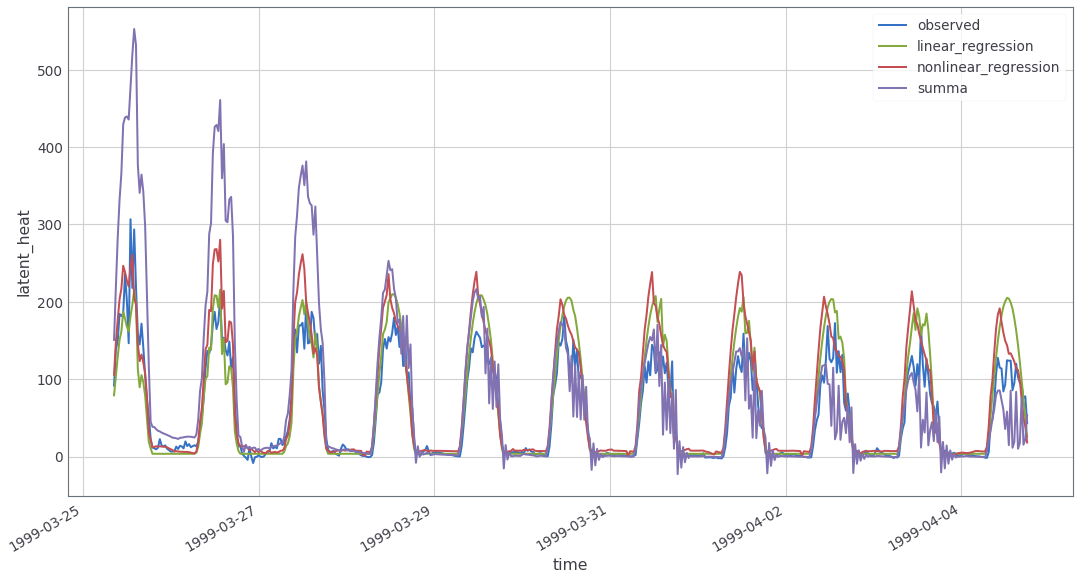

In [14]:
out =  postprocess(xr.open_dataset('../sites/Mopane/summa_output/Mopane_output_test_topmodl_timestep.nc'))

ts = slice(4000, 4500)
obs['Qle'].isel(time=ts).plot(label='observed', linewidth=2)
bench['Qle_1lin'].isel(time=ts).plot(label='linear_regression', linewidth=2)
bench['Qle_3km27'].isel(time=ts).plot(label='nonlinear_regression', linewidth=2)
out['latent_heat'].isel(time=ts).plot(label='summa', linewidth=2)
plt.legend()

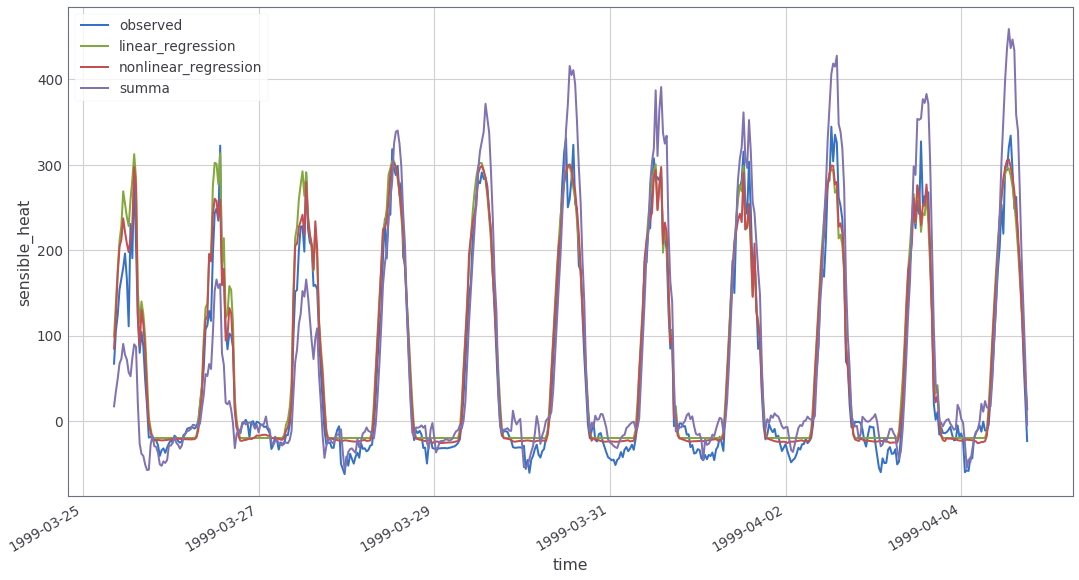

In [15]:
obs['Qh'].isel(time=ts).plot(label='observed', linewidth=2)
bench['Qh_1lin'].isel(time=ts).plot(label='linear_regression', linewidth=2)
bench['Qh_3km27'].isel(time=ts).plot(label='nonlinear_regression', linewidth=2)
out['sensible_heat'].isel(time=ts).plot(label='summa', linewidth=2)
plt.legend()

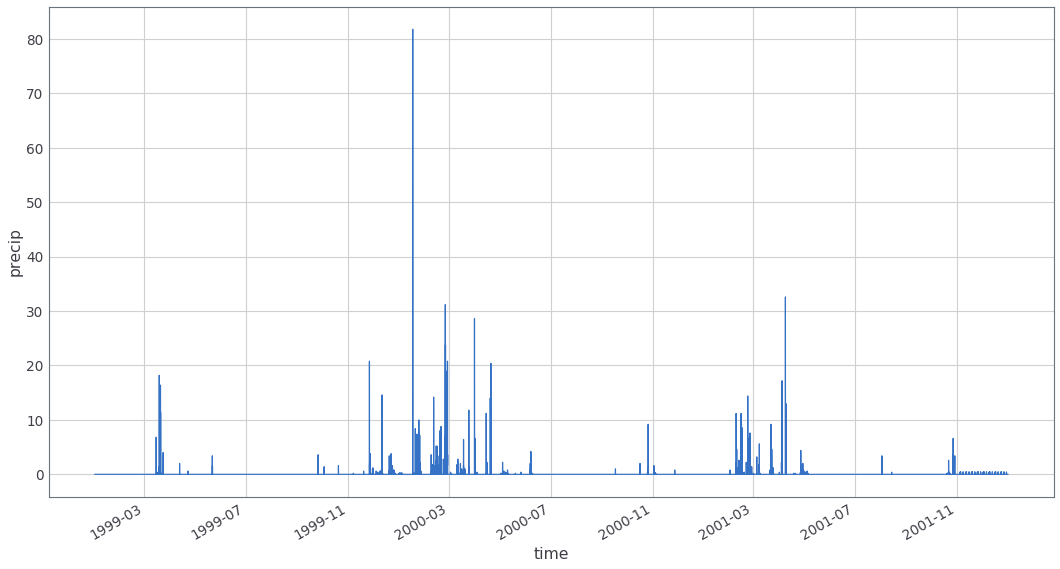

In [18]:
out['precip'].plot()

In [21]:
entropy_sk(out['precip'].values)

3.7732899529267931

In [ ]:
obs

In [ ]:
def rmse(da1, da2):
    return np.sqrt(np.mean(np.power(da1-da2,2))).values

def mbe(da1, da2):
    return (np.sum(da1-da2) / len(da1.values)).values

def r(da1, da2):
    return scipy.stats.pearsonr(da1.values.flatten(),
                                da2.values.flatten())[0]

def dtw(da1, da2):
    return fastdtw(da1.values.flatten(), da2.values.flatten())[0]

In [ ]:
print(rmse(out['latent_heat'], obs['Qle']))
print(mbe(out['latent_heat'], obs['Qle']))
print(r(out['latent_heat'], obs['Qle']))
print(dtw(out['latent_heat'], obs['Qle']))

In [ ]:
print(rmse(out['sensible_heat'], obs['Qh']))
print(mbe(out['sensible_heat'], obs['Qh']))
print(r(out['sensible_heat'], obs['Qh']))
print(dtw(out['sensible_heat'], obs['Qh']))

In [ ]:
print(rmse(bench['Qle_2lin'], obs['Qle']))
print(mbe(bench['Qle_2lin'], obs['Qle']))
print(r(bench['Qle_2lin'], obs['Qle']))

In [ ]:
print(rmse(bench['Qle_3km27'], obs['Qle']))
print(mbe(bench['Qle_3km27'], obs['Qle']))
print(r(bench['Qle_3km27'], obs['Qle']))

In [ ]:
print(rmse(bench['Qle_1lin'], obs['Qle']))
print(mbe(bench['Qle_1lin'], obs['Qle']))
print(r(bench['Qle_1lin'], obs['Qle']))

In [ ]:
obs['GPP'].plot()

In [90]:
a = np.ones((3,2))
b = np.ones((3,3))
c = np.ones((3,1))
np.hstack((a,b,c))

array([[ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.]])

In [91]:
print(a.shape, b.shape, c.shape)

(3, 2) (3, 3) (3, 1)
